## Drifter plots

In [1]:
#from mpl_toolkits.basemap import Basemap
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
from matplotlib.collections import LineCollection
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import xarray as xr
import os
from collections import OrderedDict
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cmocean
import cmocean.cm as cmo
import gsw
from itertools import cycle

# some colors (prettier than default boring colors)
color2 = '#6495ed'
color1 = '#ff6347'
color5 = '#8470ff'
color3 = '#3cb371'
color4 = '#ffd700'
color6 = '#ba55d3'

lightthermal = cmocean.tools.crop_by_percent(cmo.thermal, 5, which='min', N=None)

plt.close(fig='all') # plots stay open with widget until closed; might have to run this often

#matplotlib.get_configdir()
plt.style.use('/Users/North/.matplotlib/manuscript.mplstyle')

T_range = np.array((15,18))
S_range = np.array((35.,35.6))
N_range = np.array((-5,-3))
sigma_range = np.array((24.2,27.2))
sigma_levels = np.arange(sigma_range[0]-0.2,sigma_range[1]+.2,0.05)
theta_levels = np.arange(T_range[0],T_range[1],0.5)
U_range = np.array((-0.5,0.5))

os.chdir("/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela") # need to set working directory to get .nc file access
sadcp_nc_dir = './netcdf_files/'
figure_dir = './figures/paper/'


In [2]:
def label_axes(fig, labels=None, loc=None, **kwargs):
    """
    rpn: copied on 25.9.2010 from: https://gist.github.com/tacaswell/9643166
    Walks through axes and labels each.
    kwargs are collected and passed to `annotate`
    Parameters
    ----------
    fig : Figure
         Figure object to work on
    labels : iterable or None
        iterable of strings to use to label the axes.
        If None, lower case letters are used.
    loc : len=2 tuple of floats
        Where to put the label in axes-fraction units
    """
    if labels is None:
        labels = string.ascii_lowercase
        
    # re-use labels rather than stop labeling
    labels = cycle(labels)
    if loc is None:
        loc = (.9, .9)
    for ax, lab in zip(fig.axes, labels):
        ax.annotate(lab, xy=loc,
                    xycoords='axes fraction',
                    **kwargs)


In [19]:
# ====== Load in data
# ======  full drifter data set
drifter_ds = xr.open_dataset(sadcp_nc_dir+'drifter_Dataset.nc')
# Ro estimated for drifters
drifter_Ro = xr.open_dataset(sadcp_nc_dir+'drifter_clusters_Ro_Div_Release1_2.nc')


In [4]:
# *** cleaning up drifter data
def replace_outliers(data, dim='time', perc=0.99):
    # calculate percentile 
    threshold = data.quantile(perc,dim=dim)
    # find outliers and replace them with nan
    mask = xr.where((data <= threshold) & (data >= -threshold),data,np.nan)
    return mask

drifter_Ro_clean = drifter_Ro.set_coords(['lat','lon','lat_res','lon_res'])
drifter_Ro_clean_sel = replace_outliers(drifter_Ro_clean[['RossbyNumber','Divergence']], dim='time', perc=0.99)
drifter_Ro_clean['RossbyNumber'] = drifter_Ro_clean_sel.RossbyNumber
drifter_Ro_clean['Divergence'] = drifter_Ro_clean_sel.Divergence

drifter_Ro_clean

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


<xarray.Dataset>
Dimensions:           (calc_method: 2, drifter_cluster: 4, drifter_release: 3, ke_type: 3, time: 2176, velocity_type: 8)
Coordinates:
  * drifter_cluster   (drifter_cluster) int64 1 2 3 4
  * time              (time) datetime64[ns] 2016-11-21T13:59:59.999993 ... 20...
    lat               (drifter_release, drifter_cluster, time) float64 ...
    lon               (drifter_release, drifter_cluster, time) float64 ...
  * calc_method       (calc_method) object 'Triangle' 'LeastSquared'
  * drifter_release   (drifter_release) int64 1 2 3
    z                 int64 ...
    lat_res           (drifter_release, drifter_cluster, time) float64 ...
    lon_res           (drifter_release, drifter_cluster, time) float64 ...
  * velocity_type     (velocity_type) object 'vbar' 'vins' ... 'velocity'
  * ke_type           (ke_type) object 'ke_from_uv' 'ke_from_vbar' 'ke_from_cv'
    quantile          float64 0.99
Data variables:
    RossbyNumber      (drifter_release, calc_method, drifter_cluster, time) float64 ...
    Divergence        (drifter_release, calc_method, drifter_cluster, time) float64 ...
    temperature       (drifter_release, drifter_cluster, time) float64 ...
    ellipse_velocity  (drifter_release, drifter_cluster, velocity_type, time) float64 ...
    kinetic_energy    (drifter_release, drifter_cluster, ke_type, time) float64 ...

In [5]:
# load wind reanalysis
# data retrieved on 1.9.2020 from https://psl.noaa.gov/data/gridded/data.ncep.reanalysis.surface.html
nc_dir = '/Users/North/Drive/Work/UniH_Work/DataAnalysis/jlab_files/Benguela/netcdf_files/'
vwnd = xr.open_dataset(nc_dir+'X134.100.40.75.244.2.19.22.nc')
uwnd =  xr.open_dataset(nc_dir+'X134.100.40.75.244.2.17.11.nc')
wind_ds = xr.merge((vwnd,uwnd))
wind_sel = wind_ds.sel(lon=slice(6,13),lat=slice(-24,-28)).mean(('lat','lon')).squeeze()
wind_sel['WindSpeed'] = ((wind_sel.uwnd**2+wind_sel.vwnd**2)**0.5)


In [47]:
d_rel1_cl1.plot.scatter(x='lon',y='lat',hue='drifter',s=1)

NameError: name 't_sel' is not defined

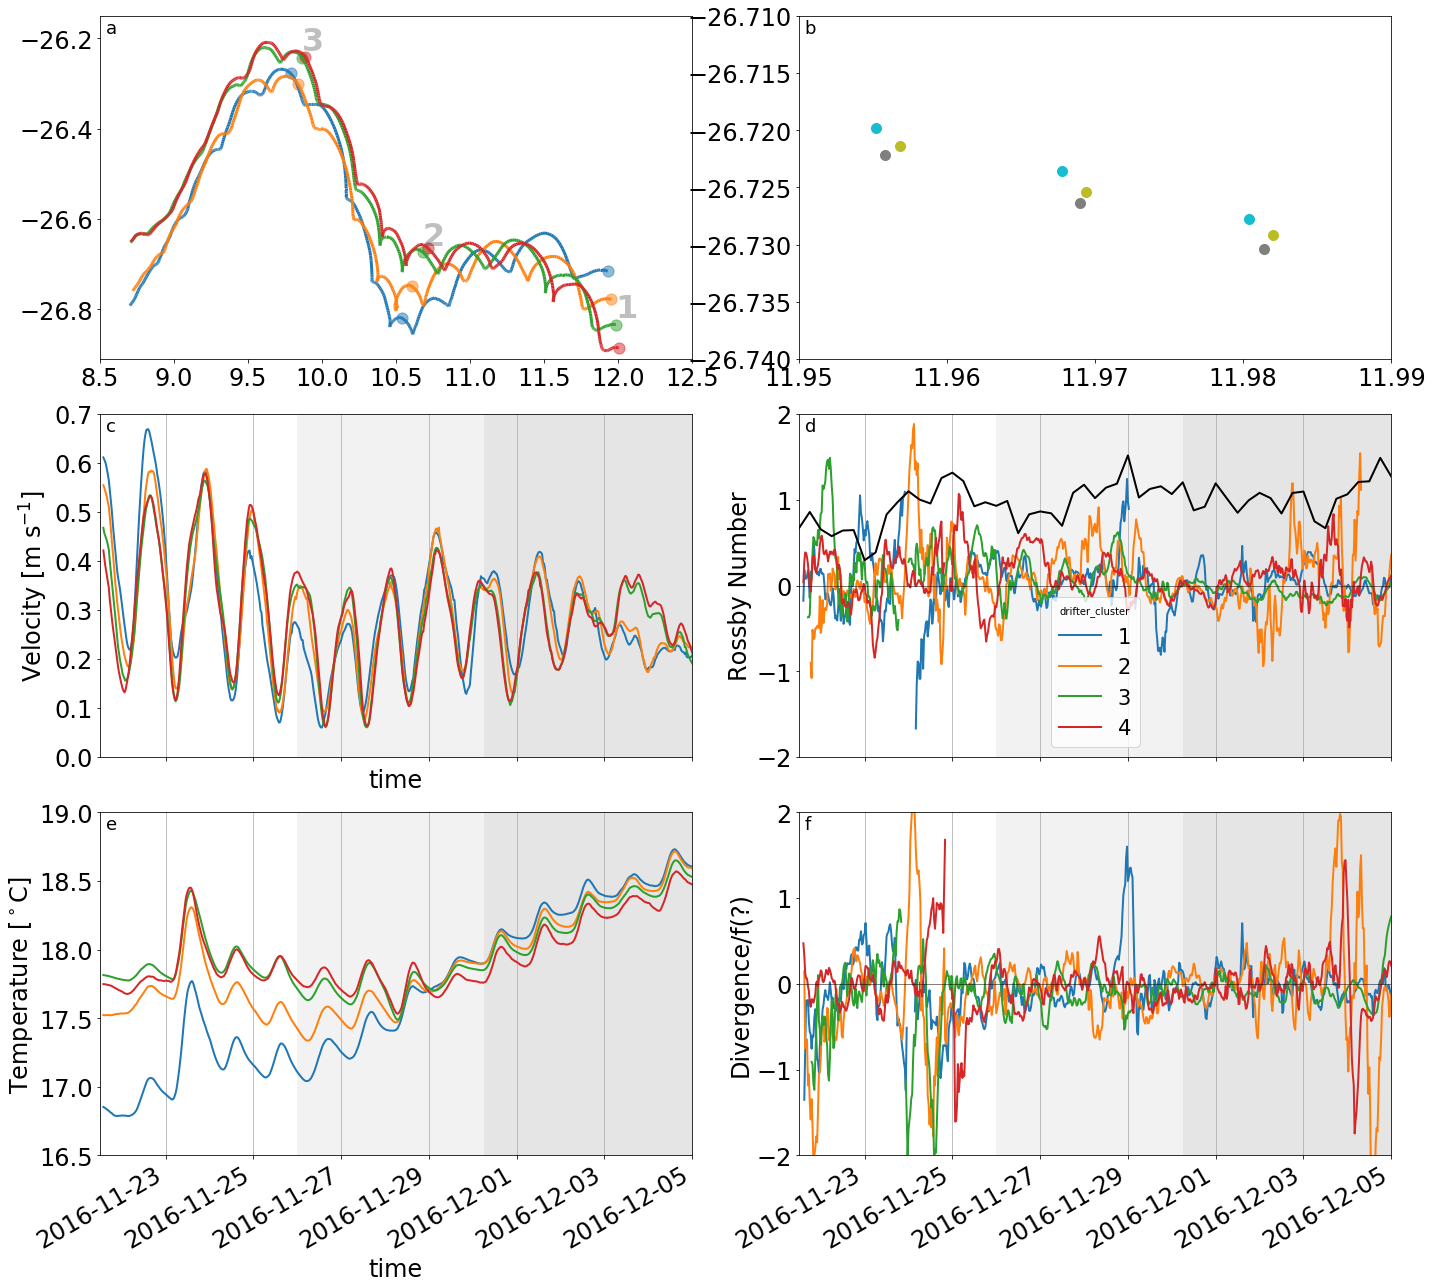

In [78]:
# newest version; two maps, no daily average

si, nrows, ncols =  0, 3, 2
fig, axss = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axss = axss.ravel()
x_y_lim = [8.5,12.5,-26.15,-26.91]
x_y_lim_zoom = [11.95,11.99,-26.71,-26.74]

##                                        outside faster   change dir    T&V swap/div lower  V flat/Ro low/change dir     
#transitions = np.array(['2016-11-21T12','2016-11-23T12','2016-11-26T00','2016-11-29T00',   '2016-11-30T06',
#                    '2016-12-02T12', #breakup?
#                    '2016-12-05T00'], dtype='datetime64')
# just direction changes
transitions = np.array(['2016-11-21T12','2016-11-26T00','2016-11-30T06','2016-12-05T00'], dtype='datetime64')
t_slice = slice(transitions[0], transitions[-1])

axs=axss[si]
for cik,c in zip(drifter_Ro_clean.drifter_cluster,plt.cm.tab10((np.linspace(0,1,10)))):
    lon = (drifter_Ro_clean.sel(drifter_release=1,time=t_slice,calc_method='Triangle',drifter_cluster=cik).
         rolling(time=12,center=True,min_periods=6).mean(skipna=True)[['RossbyNumber']].lon.values)
    lat = (drifter_Ro_clean.sel(drifter_release=1,time=t_slice,calc_method='Triangle',drifter_cluster=cik).
         rolling(time=12,center=True,min_periods=6).mean(skipna=True)[['RossbyNumber']].lat.values)
    
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, colors=c, zorder=100,  linestyle='solid')
    lc.set_linewidth(3)
    axs.add_collection(lc)

    # phases
    vline = drifter_Ro_clean.sel(drifter_release=1,drifter_cluster=cik,calc_method='Triangle').sel(time=transitions,method='nearest')
    for _x,_y,cic in zip(vline.isel(time=slice(0,3)).lon.values,vline.lat.values,range(vline.isel(time=slice(0,3)).lon.size)): 
        conmap = vline.isel(time=cic).plot.scatter(x='lon',y='lat',add_guide=False,ax=axs,color=c,s=125, alpha=0.5,zorder=1)
        if cik==3:
            axs.text(_x,_y,cic+1,color='k',alpha=0.25,horizontalalignment='left',verticalalignment='bottom',fontsize=32,
                     weight='heavy',zorder=1)


axs.set_title('')
axs.set_xlim(x_y_lim[0:2])#, projection)
axs.set_ylim(x_y_lim[3],x_y_lim[2])
axs.set_xlabel('')
axs.set_ylabel('')

axs.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

# === Zoom on drifter triplet
si=si+1
axs=axss[si]
# select the first release and the first cluster of that release
d_rel1 = drifter_ds.sel(drifter=drifter_ds.drifter_release==1,time=t_slice)
d_rel1_cl1 = d_rel1.sel(drifter=d_rel1.drifter_cluster==1)
axs.plot(d_rel1_cl1.lon.isel(drifter=0).values, d_rel1_cl1.lat.isel(drifter=0).values,marker='o',color=plt.cm.tab10(0.9),linestyle='')
axs.plot(d_rel1_cl1.lon.isel(drifter=1).values, d_rel1_cl1.lat.isel(drifter=1).values,marker='o',color=plt.cm.tab10(0.8),linestyle='')
axs.plot(d_rel1_cl1.lon.isel(drifter=2).values, d_rel1_cl1.lat.isel(drifter=2).values,marker='o',color=plt.cm.tab10(0.7),linestyle='')
#d_rel1_cl1.plot.scatter(x='lon',y='lat',hue='drifter',colors=plt.cm.binary((np.linspace(0,1,10))),ax=axs)

axs.set_title('')
axs.set_xlim(x_y_lim_zoom[0:2])#, projection)
axs.set_ylim(x_y_lim_zoom[3],x_y_lim_zoom[2])
axs.set_xlabel('')
axs.set_ylabel('')

# === Velocity
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(velocity_type='velocity',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).ellipse_velocity).
 plot(hue='drifter_cluster',ax=axs,add_legend=False))
axs.set_ylabel('Velocity [m s$^{-1}$]')
axs.set_ylim(0.,0.7)
axs.set_xlim(transitions[0],transitions[-1])
axs.grid(axis='x')
axs.set_title('')
color=plt.cm.gray_r((np.linspace(0,1,6)))[0:vline.time.values.size]
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)
axs.set_xticklabels('')

# === Ro
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(calc_method='Triangle',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).RossbyNumber).
 plot(hue='drifter_cluster',ax=axs))
((wind_sel[['WindSpeed']].sel(time=t_slice).WindSpeed/10).
 plot(color='black',ax=axs))
axs.set_ylabel('Rossby Number')
axs.set_ylim(-2,2)
axs.set_xlim(transitions[0],transitions[-1])
axs.set_title('')
axs.grid(axis='x')
color=plt.cm.gray_r((np.linspace(0,1,6)))[0:vline.time.values.size]
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)

axs.set_xticklabels(''), axs.set_xlabel('')
axs.axhline(0,color='k',linewidth=0.5)

# === Temperature
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(calc_method='Triangle',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).temperature).
 plot(hue='drifter_cluster',ax=axs,add_legend=False))
axs.set_ylabel('Temperature [$^\circ$C]')
axs.set_ylim(16.5,19)
axs.set_xlim(transitions[0],transitions[-1])
axs.grid(axis='x')  
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)
axs.set_title('')

# === Divergence
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(calc_method='Triangle',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).Divergence).
 plot(hue='drifter_cluster',ax=axs,add_legend=False))
axs.set_ylabel('Divergence/f(?)')
axs.set_ylim(-2,2)
axs.set_xlim(transitions[0],transitions[-1])
axs.grid(axis='x')
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)
axs.set_title('')
#axs.set_xticklabels(''), 
axs.set_xlabel('')
axs.axhline(0,color='k',linewidth=0.5)

# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','d','e','f','','','')),loc=(0.01,0.95),size=18)
plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_timeseries_Drifters_mapx2_T_vel_Ro_Div.pdf'
fig.savefig(figname, dpi=300, transparent=True)

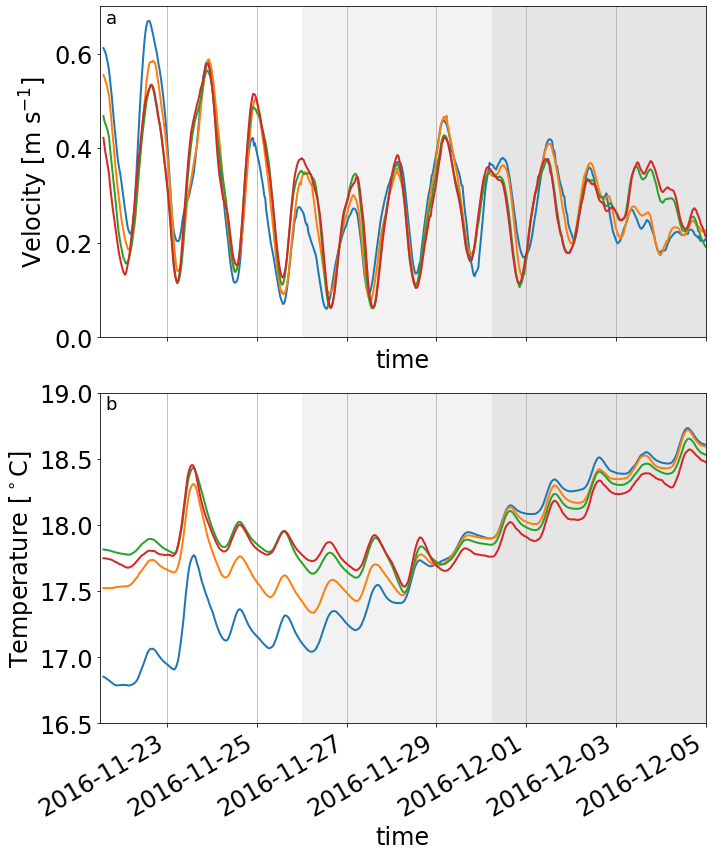

In [76]:
# 2 subplots version

si, nrows, ncols =  0, 2, 1
fig, axss = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axss = axss.ravel()
x_y_lim = [8.5,12.5,-26.15,-26.91]

##                                        outside faster   change dir    T&V swap/div lower  V flat/Ro low/change dir     
#transitions = np.array(['2016-11-21T12','2016-11-23T12','2016-11-26T00','2016-11-29T00',   '2016-11-30T06',
#                    '2016-12-02T12', #breakup?
#                    '2016-12-05T00'], dtype='datetime64')
# just direction changes
transitions = np.array(['2016-11-21T12','2016-11-26T00','2016-11-30T06','2016-12-05T00'], dtype='datetime64')
t_slice = slice(transitions[0], transitions[-1])

# easier to comment out than delete
#axs=axss[si]
for cik,c in zip(drifter_Ro_clean.drifter_cluster,plt.cm.tab10((np.linspace(0,1,10)))):
    lon = (drifter_Ro_clean.sel(drifter_release=1,time=t_slice,calc_method='Triangle',drifter_cluster=cik).
         rolling(time=12,center=True,min_periods=6).mean(skipna=True)[['RossbyNumber']].lon.values)
    lat = (drifter_Ro_clean.sel(drifter_release=1,time=t_slice,calc_method='Triangle',drifter_cluster=cik).
         rolling(time=12,center=True,min_periods=6).mean(skipna=True)[['RossbyNumber']].lat.values)
    Ro = (drifter_Ro_clean.sel(drifter_release=1,time=t_slice,calc_method='Triangle',drifter_cluster=cik).
         rolling(time=12,center=True,min_periods=6).mean(skipna=True)[['RossbyNumber']].RossbyNumber.values)
    
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    #lc = LineCollection(segments, cmap=cmo.balance,zorder=100,clim=(-1,1))
    #lc.set_linewidth(3)
    #lc.set_array(np.ma.masked_invalid(Ro)) # taking out nan values
    #axs.add_collection(lc)

    # phases
    vline = drifter_Ro_clean.sel(drifter_release=1,drifter_cluster=cik,calc_method='Triangle').sel(time=transitions,method='nearest')
    #for _x,_y,cic in zip(vline.isel(time=slice(0,3)).lon.values,vline.lat.values,range(vline.isel(time=slice(0,3)).lon.size)): 
    #    conmap = vline.isel(time=cic).plot.scatter(x='lon',y='lat',add_guide=False,ax=axs,color=c,s=125, alpha=0.5,zorder=1)
    #    if cik==3:
    #        axs.text(_x,_y,cic+1,color='k',alpha=0.25,horizontalalignment='left',verticalalignment='bottom',fontsize=32,
    #                 weight='heavy',zorder=1)


#axs.set_title('')
#axs.set_xlim(x_y_lim[0:2])#, projection)
#axs.set_ylim(x_y_lim[3],x_y_lim[2])
#axs.set_xlabel('')
#axs.set_ylabel('')

#mappable = axs.collections[0]
#cbaxes = inset_axes(axs, width="35%", height="5%", loc=1) 
#plt.colorbar(mappable, cax=cbaxes, orientation='horizontal')
#axs.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

# === Velocity
si=0#si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(velocity_type='velocity',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).ellipse_velocity).
 plot(hue='drifter_cluster',ax=axs,add_legend=False))
axs.set_ylabel('Velocity [m s$^{-1}$]')
axs.set_ylim(0.,0.7)
axs.set_xlim(transitions[0],transitions[-1])
axs.grid(axis='x')
axs.set_title('')
color=plt.cm.gray_r((np.linspace(0,1,6)))[0:vline.time.values.size]
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)
axs.set_xticklabels('')
    
# === Temperature
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(calc_method='Triangle',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).temperature).
 plot(hue='drifter_cluster',ax=axs,add_legend=False))
axs.set_ylabel('Temperature [$^\circ$C]')
axs.set_ylim(16.5,19)
axs.set_xlim(transitions[0],transitions[-1])
axs.grid(axis='x')  
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)
axs.set_title('')

# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','','','')),loc=(0.01,0.95),size=18)
plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_timeseries_Drifters_map_T_vel.pdf'
fig.savefig(figname, dpi=300, transparent=True)

/Users/North/opt/anaconda3/envs/WORK1/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


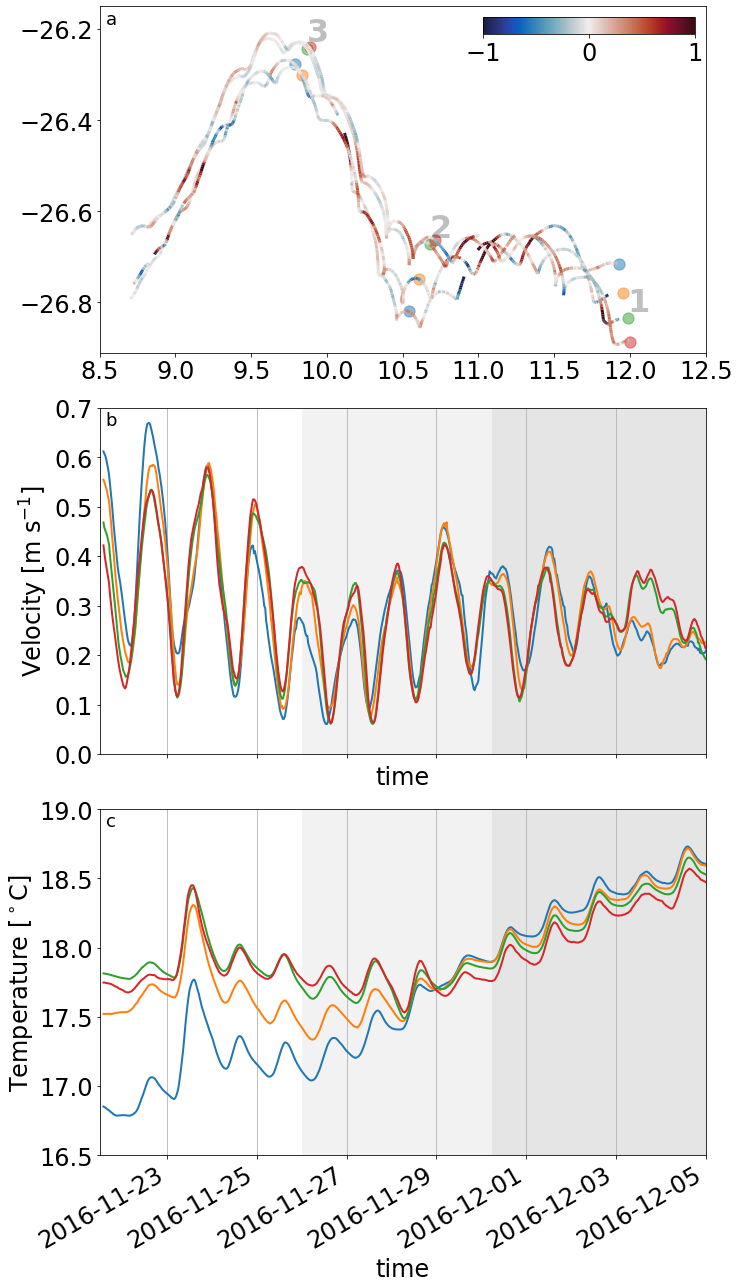

In [6]:
si, nrows, ncols =  0, 3, 1
fig, axss = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axss = axss.ravel()
x_y_lim = [8.5,12.5,-26.15,-26.91]

##                                        outside faster   change dir    T&V swap/div lower  V flat/Ro low/change dir     
#transitions = np.array(['2016-11-21T12','2016-11-23T12','2016-11-26T00','2016-11-29T00',   '2016-11-30T06',
#                    '2016-12-02T12', #breakup?
#                    '2016-12-05T00'], dtype='datetime64')
# just direction changes
transitions = np.array(['2016-11-21T12','2016-11-26T00','2016-11-30T06','2016-12-05T00'], dtype='datetime64')
t_slice = slice(transitions[0], transitions[-1])

axs=axss[si]
for cik,c in zip(drifter_Ro_clean.drifter_cluster,plt.cm.tab10((np.linspace(0,1,10)))):
    lon = (drifter_Ro_clean.sel(drifter_release=1,time=t_slice,calc_method='Triangle',drifter_cluster=cik).
         rolling(time=12,center=True,min_periods=6).mean(skipna=True)[['RossbyNumber']].lon.values)
    lat = (drifter_Ro_clean.sel(drifter_release=1,time=t_slice,calc_method='Triangle',drifter_cluster=cik).
         rolling(time=12,center=True,min_periods=6).mean(skipna=True)[['RossbyNumber']].lat.values)
    Ro = (drifter_Ro_clean.sel(drifter_release=1,time=t_slice,calc_method='Triangle',drifter_cluster=cik).
         rolling(time=12,center=True,min_periods=6).mean(skipna=True)[['RossbyNumber']].RossbyNumber.values)
    
    points = np.array([lon, lat]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmo.balance,zorder=100,clim=(-1,1))
    lc.set_linewidth(3)
    lc.set_array(np.ma.masked_invalid(Ro)) # taking out nan values
    axs.add_collection(lc)

    # phases
    vline = drifter_Ro_clean.sel(drifter_release=1,drifter_cluster=cik,calc_method='Triangle').sel(time=transitions,method='nearest')
    for _x,_y,cic in zip(vline.isel(time=slice(0,3)).lon.values,vline.lat.values,range(vline.isel(time=slice(0,3)).lon.size)): 
        conmap = vline.isel(time=cic).plot.scatter(x='lon',y='lat',add_guide=False,ax=axs,color=c,s=125, alpha=0.5,zorder=1)
        if cik==3:
            axs.text(_x,_y,cic+1,color='k',alpha=0.25,horizontalalignment='left',verticalalignment='bottom',fontsize=32,
                     weight='heavy',zorder=1)


axs.set_title('')
axs.set_xlim(x_y_lim[0:2])#, projection)
axs.set_ylim(x_y_lim[3],x_y_lim[2])
axs.set_xlabel('')
axs.set_ylabel('')

mappable = axs.collections[0]
cbaxes = inset_axes(axs, width="35%", height="5%", loc=1) 
plt.colorbar(mappable, cax=cbaxes, orientation='horizontal')
axs.set_rasterized(True) # !! to reduce file size make this image, rest stays vectors

# === Velocity
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(velocity_type='velocity',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).ellipse_velocity).
 plot(hue='drifter_cluster',ax=axs,add_legend=False))
axs.set_ylabel('Velocity [m s$^{-1}$]')
axs.set_ylim(0.,0.7)
axs.set_xlim(transitions[0],transitions[-1])
axs.grid(axis='x')
axs.set_title('')
color=plt.cm.gray_r((np.linspace(0,1,6)))[0:vline.time.values.size]
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)
axs.set_xticklabels('')
    
# === Temperature
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(calc_method='Triangle',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).temperature).
 plot(hue='drifter_cluster',ax=axs,add_legend=False))
axs.set_ylabel('Temperature [$^\circ$C]')
axs.set_ylim(16.5,19)
axs.set_xlim(transitions[0],transitions[-1])
axs.grid(axis='x')  
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)
axs.set_title('')

# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','','','')),loc=(0.01,0.95),size=18)
plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_timeseries_Drifters_map_T_vel.pdf'
fig.savefig(figname, dpi=300, transparent=True)

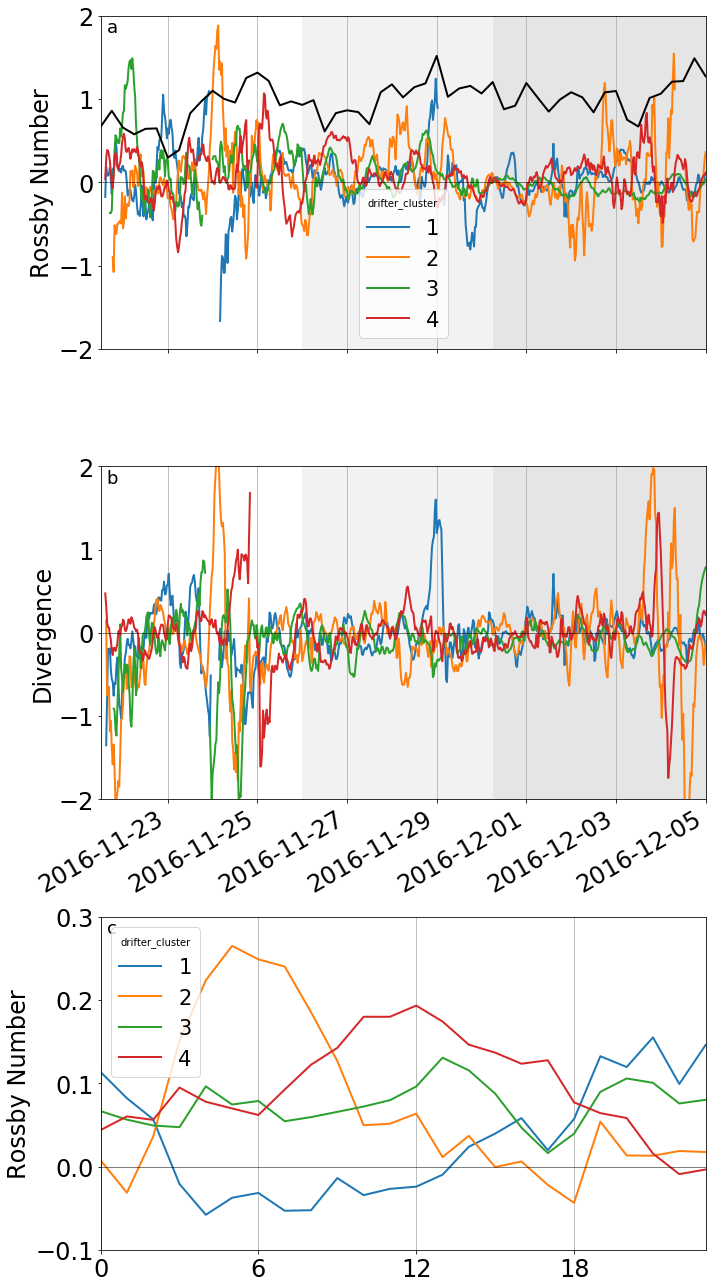

In [7]:
si, nrows, ncols =  0, 3, 1
fig, axss = plt.subplots(nrows=nrows,ncols=ncols,figsize = (ncols*10.,nrows*6))
axss = axss.ravel()
x_y_lim = [8.5,12.5,-26.15,-26.91]

transitions = np.array(['2016-11-21T12','2016-11-26T00','2016-11-30T06','2016-12-05T00'], dtype='datetime64')
t_slice = slice(transitions[0], transitions[-1])

# === Ro
si=0
axs=axss[si]
((drifter_Ro_clean.
        sel(calc_method='Triangle',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).RossbyNumber).
 plot(hue='drifter_cluster',ax=axs))
((wind_sel[['WindSpeed']].sel(time=t_slice).WindSpeed/10).
 plot(color='black',ax=axs))
axs.set_ylabel('Rossby Number')
axs.set_ylim(-2,2)
axs.set_xlim(transitions[0],transitions[-1])
axs.set_title('')
axs.grid(axis='x')
color=plt.cm.gray_r((np.linspace(0,1,6)))[0:vline.time.values.size]
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)

axs.set_xticklabels(''), axs.set_xlabel('')
axs.axhline(0,color='k',linewidth=0.5)

# === Divergence
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(calc_method='Triangle',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).Divergence).
 plot(hue='drifter_cluster',ax=axs,add_legend=False))
axs.set_ylabel('Divergence')
axs.set_ylim(-2,2)
axs.set_xlim(transitions[0],transitions[-1])
axs.grid(axis='x')
for _x,c in zip(range(vline.time[:-1].size),color): 
    axs.axvspan(vline.time[_x].values,vline.time[_x+1].values, facecolor=c, alpha=0.25,zorder=0)
axs.set_title('')
#axs.set_xticklabels(''), 
axs.set_xlabel('')
axs.axhline(0,color='k',linewidth=0.5)

# === Ro hourly mean
si=si+1
axs=axss[si]
((drifter_Ro_clean.
        sel(calc_method='Triangle',drifter_release=1,time=t_slice).
        rolling(time=12,center=True,min_periods=6).mean(skipna=True).groupby("time.hour").mean().RossbyNumber).
 plot(hue='drifter_cluster',ax=axs))
axs.set_xlim(0,23)
axs.set_ylim(-0.1,0.3)
axs.set_ylabel('Rossby Number')
axs.set_xticks(np.arange(0,24,6))
axs.set_title('')
axs.grid(axis='x')
axs.axhline(0,color='k',linewidth=0.5)
axs.set_xlabel('')

# add letter labels - account for colorbars as axes
label_axes(fig,labels=np.array(('a','b','c','','','')),loc=(0.01,0.95),size=18)
plt.tight_layout() # squeeze subplots together

figname = figure_dir+'Figure_timeseries_Drifters_Ro_Div.pdf'
fig.savefig(figname, dpi=300, transparent=True)